In [1]:
# Install necessary packages
!pip install --upgrade pip
!pip install --upgrade tensorflow
%env TF_ENABLE_ONEDNN_OPTS=0
!pip install seaborn
!pip install -q efficientnet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.2 MB/s eta 0:00:0000:010:01
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 477.8 kB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 11.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 1.8 MB/s eta 0:00:00:00:01
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: tensorboard
    Found existing inst

In [2]:
# Import required libraries
import os
import time
import shutil
import pathlib
import itertools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.layers import Input, Concatenate, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3


2023-12-16 14:26:12.716104: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-16 14:26:12.716168: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-16 14:26:12.717874: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Define a learning rate callback
def lr_rate(epoch, lr):
    if epoch < 10:
        lr = 0.0001
        return lr
    elif 10 <= epoch < 15:
        lr = 0.0005
        return lr
    elif 15 <= epoch < 30:
        lr = 0.0001
        return lr
    else:
        lr = lr * (epoch / (1 + epoch))
        return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_rate)

In [4]:
# Load data using ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             validation_split=0.2)


In [5]:
train_data = datagen.flow_from_directory('/kaggle/input/diabetic-retinopathy-224x224-grayscale-images/grayscale_images/grayscale_images',
                                         target_size=(224, 224),
                                         batch_size=32,
                                         class_mode='categorical',
                                         color_mode='grayscale',
                                         subset='training')

valid_data = datagen.flow_from_directory('/kaggle/input/diabetic-retinopathy-224x224-grayscale-images/grayscale_images/grayscale_images',
                                         target_size=(224, 224),
                                         batch_size=32,
                                         class_mode='categorical',
                                         color_mode='grayscale',
                                         subset='validation')


Found 2931 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [6]:
# Create InceptionV3 model
base_model = InceptionV3(weights='/kaggle/input/weightss/inception_v3_weights_tf_dim_ordering_tf_kernels_notop (1).h5', include_top=False, input_shape=(224, 224, 3))


In [7]:
# Create a model with a single-channel input
input_layer = Input(shape=(224, 224, 1))
x = Concatenate()([input_layer, input_layer, input_layer])  # Duplicate the single-channel input into three channels
x = base_model(x)
x = GlobalAveragePooling2D()(x)
output_layer = Dense(5, activation='softmax')(x)

# Create the final model
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

In [8]:
# Compile the model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 concatenate_2 (Concatenate  (None, 224, 224, 3)          0         ['input_2[0][0]',             
 )                                                                   'input_2[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 inception_v3 (Functional)   (None, 5, 5, 2048)           2180278   ['concatenate_2[0][0]']       
                                                          4                                   

In [17]:
# Train the model
history = model.fit(train_data, validation_data=valid_data, callbacks=[lr_callback], epochs=40, verbose=1)

Epoch 1/40
92/92 [==============================] - 121s 1s/step - loss: 0.1230 - accuracy: 0.9604 - val_loss: 0.9077 - val_accuracy: 0.7756 - lr: 1.0000e-04
Epoch 2/40
92/92 [==============================] - 121s 1s/step - loss: 0.0960 - accuracy: 0.9669 - val_loss: 0.9035 - val_accuracy: 0.7661 - lr: 1.0000e-04
Epoch 3/40
92/92 [==============================] - 120s 1s/step - loss: 0.0899 - accuracy: 0.9690 - val_loss: 0.9809 - val_accuracy: 0.7729 - lr: 1.0000e-04
Epoch 4/40
92/92 [==============================] - 120s 1s/step - loss: 0.1033 - accuracy: 0.9635 - val_loss: 0.8850 - val_accuracy: 0.7688 - lr: 1.0000e-04
Epoch 5/40
92/92 [==============================] - 120s 1s/step - loss: 0.0766 - accuracy: 0.9734 - val_loss: 0.8698 - val_accuracy: 0.7907 - lr: 1.0000e-04
Epoch 6/40
92/92 [==============================] - 120s 1s/step - loss: 0.0745 - accuracy: 0.9741 - val_loss: 1.0888 - val_accuracy: 0.7674 - lr: 1.0000e-04
Epoch 7/40
92/92 [==============================] - 

In [18]:
# Evaluate the model on test data
test_data = datagen.flow_from_directory('../input/diabetic-retinopathy-224x224-grayscale-images/grayscale_images/grayscale_images',
                                        target_size=(224, 224),
                                        batch_size=32,
                                        class_mode='categorical',
                                        color_mode='grayscale',
                                        subset='validation')

Found 731 images belonging to 5 classes.


In [19]:
test_data = datagen.flow_from_directory('/kaggle/input/diabetic-retinopathy-224x224-grayscale-images/grayscale_images/grayscale_images',
                                        target_size=(224, 224),
                                        batch_size=32,
                                        class_mode='categorical',
                                        color_mode='grayscale',
                                        subset='validation')

Found 731 images belonging to 5 classes.


In [20]:
# Load test data
test_data = datagen.flow_from_directory('../input/diabetic-retinopathy-224x224-grayscale-images/grayscale_images/grayscale_images',
                                        target_size=(224, 224),
                                        batch_size=32,
                                        class_mode='categorical',
                                        color_mode='grayscale',
                                        subset='validation')

# Predictions on test data
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())


Found 731 images belonging to 5 classes.
23/23 [==============================] - 6s 247ms/step


In [21]:
# Classification Report
print("Classification Report:")
print(classification_report(true_classes, y_pred_classes, target_names=class_labels))

Classification Report:
                precision    recall  f1-score   support

          Mild       0.19      0.12      0.15        74
      Moderate       0.27      0.28      0.27       199
         No_DR       0.49      0.50      0.49       361
Proliferate_DR       0.09      0.12      0.10        59
        Severe       0.08      0.05      0.06        38

      accuracy                           0.35       731
     macro avg       0.22      0.21      0.22       731
  weighted avg       0.34      0.35      0.34       731



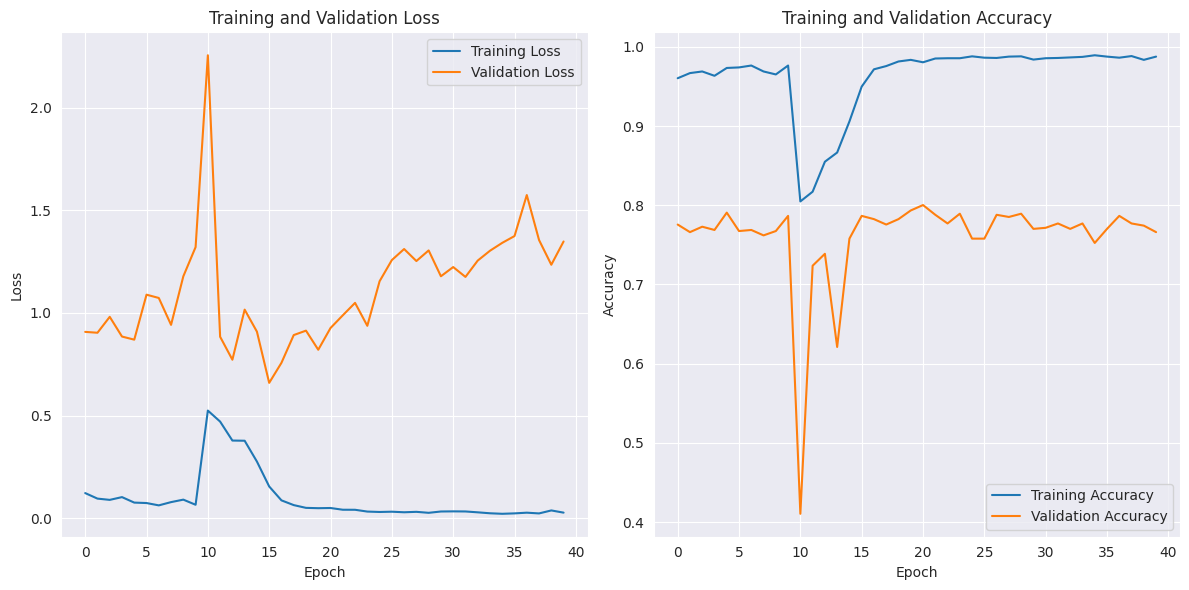

In [22]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Training and Validation Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()